In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import random

In [21]:
max_distance = 300000 # for example
n_clusters = 16

In [22]:
node_df = pd.read_csv('node.csv', index_col= 'Node')

In [27]:
x = node_df['X']
y = node_df['Y']

In [28]:
connection_df = pd.read_csv('connections.csv')

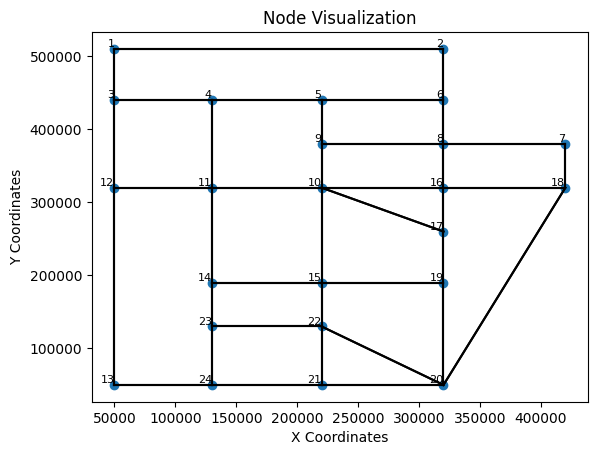

In [29]:
plt.scatter(x, y)
plt.xlabel('X Coordinates')
plt.ylabel('Y Coordinates')
plt.title('Node Visualization')
for i, (x_coord, y_coord) in enumerate(zip(x, y)):
    plt.text(x_coord, y_coord, str(i+1), fontsize=8, verticalalignment='bottom', horizontalalignment='right')
for _, row in connection_df.iterrows():
    start_node = row['A']
    end_node = row['B']
    plt.plot([x[start_node], x[end_node]], [y[start_node], y[end_node]], 'k-')
plt.show()

In [30]:
data = pd.read_csv('capacity.tntp',  delimiter='\t', skiprows=5)
headers = data.iloc[0]
data = data.iloc[0+1:].reset_index(drop=True)
data.columns = headers
data = data.drop('~', axis=1)

In [8]:
import pandas as pd
import networkx as nx
import concurrent.futures

# Read the DataFrame with connections and capacities
df = data

# Create a directed graph
G = nx.DiGraph()

# Convert capacity to integers
df['capacity'] = df['capacity'].astype(float)

# Add nodes to the graph
G.add_nodes_from(df['init_node'])
G.add_nodes_from(df['term_node'])

# Add edges to the graph with capacities as edge attributes
for _, row in df.iterrows():
    init_node = row['init_node']
    term_node = row['term_node']
    capacity = row['capacity']
    G.add_edge(init_node, term_node, capacity=capacity)

# Function to find the optimal route for a pair of nodes
def find_optimal_route(start_node, end_node):
    return nx.shortest_path(G, start_node, end_node, weight='capacity')

# Find all possible routes and select the optimal route for each pair of nodes
routes = []
with concurrent.futures.ThreadPoolExecutor() as executor:
    future_to_pair = {executor.submit(find_optimal_route, start_node, end_node): (start_node, end_node) for start_node in G.nodes for end_node in G.nodes if start_node != end_node}
    for future in concurrent.futures.as_completed(future_to_pair):
        pair = future_to_pair[future]
        try:
            optimal_route = future.result()
            route_capacity = min(G[u][v]['capacity'] for u, v in zip(optimal_route, optimal_route[1:]))
            routes.append({'start_node': pair[0], 'end_node': pair[1], 'route': optimal_route, 'capacity': route_capacity})
        except Exception as e:
            print(f"An error occurred for pair {pair}: {e}")

# Convert routes to a DataFrame
routes_df = pd.DataFrame(routes)

# Print the routes DataFrame
# print(routes_df)


In [9]:
routes_df['route_pairs'] = routes_df['route'].apply(lambda route: [f"{node}-{next_node}" for node, next_node in zip(route, route[1:])])

In [10]:
def find_distance(pair):
    node1, node2 = pair.split('-')
    x1 = node_df.iloc[int(node1) - 1]['X']
    x2 = node_df.iloc[int(node2) - 1]['X']
    y1 = node_df.iloc[int(node1) - 1]['Y']
    y2 = node_df.iloc[int(node2) - 1]['Y']
    return ((x1-x2)**2 + (y1-y2)**2)**0.5

In [11]:
distances = dict()
for i in range(len(data)):
    distance = f"{data.iloc[i]['init_node']}-{data.iloc[i]['term_node']}"
    distances[distance] = find_distance(distance)

In [12]:

# Function to calculate the summary distance for a route pair
def calculate_summary_distance(route_pairs):
    return sum(distances.get(pair, 0) for pair in route_pairs)

# Calculate the summary distances for each route_pairs entity
routes_df['summary_distance'] = routes_df['route_pairs'].apply(calculate_summary_distance)

# Print the updated routes DataFrame with summary distances
# print(routes_df)


In [13]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

# Set the max_distance a car can drive without charging
# max_distance = 300000 # for example
# n_clusters = 20

# Filter routes that a car can drive without charging
viable_routes_df = routes_df[routes_df['summary_distance'] <= max_distance]

if viable_routes_df.empty:
    raise ValueError("No viable routes! Increase max_distance.")

# Now, we'll perform clustering on the 'capacity' of the routes
# Convert 'capacity' into a 2D numpy array
X = np.array(viable_routes_df['capacity']).reshape(-1, 1)

# Number of clusters corresponds to the number of desired charging stations

kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)

# Assign each route to a cluster
viable_routes_df['cluster'] = kmeans.labels_

charging_stations = []

# For each cluster, find the route with the maximum capacity
for i in range(n_clusters):
    cluster_routes = viable_routes_df[viable_routes_df['cluster'] == i]
    
    if cluster_routes.empty:
        continue  # Skip to the next iteration if there are no routes in this cluster
    
    # Choose the first route with the maximum capacity
    best_route = cluster_routes[cluster_routes['capacity'] == cluster_routes['capacity'].max()].iloc[0]
    
    # Choose the node with the highest capacity within this route
    nodes_in_route = best_route['route']
    node_capacities = [(node, routes_df[routes_df['start_node'] == node]['capacity'].max()) for node in nodes_in_route]
    best_node, _ = max(node_capacities, key=lambda x: x[1])
    
    # Add the best_node's coordinates to the list of charging stations
    charging_stations.append(node_df.loc[int(best_node)])

# Now charging_stations contains the coordinates of the charging stations.
print(charging_stations)


[X    220000
Y    380000
Name: 9, dtype: int64, X     50000
Y    510000
Name: 1, dtype: int64, X     50000
Y    510000
Name: 1, dtype: int64, X    220000
Y    440000
Name: 5, dtype: int64, X    220000
Y    190000
Name: 15, dtype: int64, X    420000
Y    320000
Name: 18, dtype: int64, X     50000
Y    510000
Name: 1, dtype: int64, X    420000
Y    380000
Name: 7, dtype: int64, X    220000
Y    190000
Name: 15, dtype: int64, X    320000
Y     50000
Name: 20, dtype: int64, X    130000
Y    440000
Name: 4, dtype: int64, X    220000
Y    190000
Name: 15, dtype: int64, X    220000
Y    190000
Name: 15, dtype: int64, X    220000
Y    380000
Name: 9, dtype: int64, X    320000
Y    510000
Name: 2, dtype: int64, X    220000
Y    190000
Name: 15, dtype: int64]


C:\Users\PC-1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\PC-1\AppData\Local\Temp\ipykernel_14324\3205371427.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  viable_routes_df['cluster'] = kmeans.labels_


In [14]:
capacities = dict()
for i in range(len(data)):
    if data['term_node'][i] not in capacities.keys():
        capacities[data['term_node'][i]] = data['capacity'][i]
    else:
        capacities[data['term_node'][i]] += data['capacity'][i]    

In [15]:
# Convert charging_stations to a dictionary for uniqueness
charging_stations_dict = {station.name: station for station in charging_stations}

# Store the original number of charging stations
original_num_stations = len(charging_stations_dict)

# Sort the capacities dict based on values (in descending order)
sorted_capacities = dict(sorted(capacities.items(), key=lambda item: item[1], reverse=True))

# Iterate over the sorted capacities dict
for node, capacity in sorted_capacities.items():
    # If the node is not already in the charging_stations dictionary
    if int(node) not in charging_stations_dict:
        # Get the node from node_df and add it to the charging_stations dictionary
        charging_stations_dict[int(node)] = node_df.loc[int(node)]

    # Check if the number of charging stations is equal to n_clusters
    if len(charging_stations_dict) == n_clusters:
        break

# Convert the dictionary back to a list
charging_stations = list(charging_stations_dict.values())

# Calculate the number of new stations added
num_new_stations = len(charging_stations) - original_num_stations

if num_new_stations == 0 and len(charging_stations) < n_clusters:
    print("Not enough different stations to reach the desired number of clusters.")
else:
    print(f"Added {num_new_stations} new station(s) to charging_stations list.")


Added 6 new station(s) to charging_stations list.


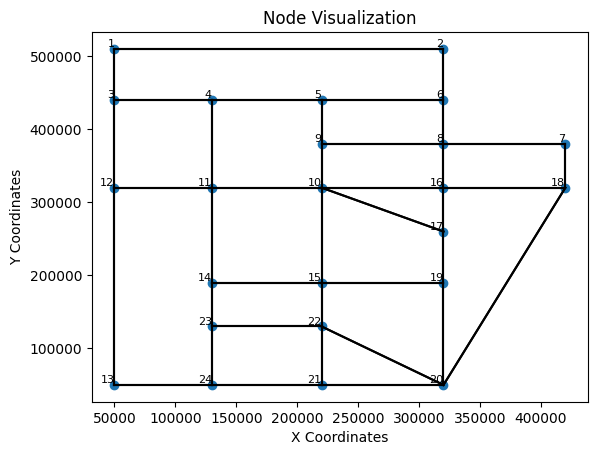

In [14]:
import matplotlib.pyplot as plt

plt.scatter(x, y)
plt.xlabel('X Coordinates')
plt.ylabel('Y Coordinates')
plt.title('Node Visualization')
for i, (x_coord, y_coord) in enumerate(zip(x, y)):
    plt.text(x_coord, y_coord, str(i+1), fontsize=8, verticalalignment='bottom', horizontalalignment='right')

# Extracting X and Y coordinates of charging stations
x_charging = [station['X'] for station in charging_stations]
y_charging = [station['Y'] for station in charging_stations]

# Plotting charging stations
plt.scatter(x_charging, y_charging, color='red')

for _, row in connection_df.iterrows():
    start_node = row['A']
    end_node = row['B']
    plt.plot([x[start_node], x[end_node]], [y[start_node], y[end_node]], 'k-')

plt.show()


In [15]:
def get_node_numbers(charging_stations, node_df):
    node_numbers = []
    for station in charging_stations:
        match = node_df[(node_df['X'] == station['X']) & (node_df['Y'] == station['Y'])]
        node_numbers.append(match.index[0])
    return node_numbers

# Call the function with your data
node_numbers = get_node_numbers(charging_stations, node_df)

# Print the node numbers of the charging stations
print(set(node_numbers))


set()


In [16]:
# def can_complete_round_trip(route, charging_stations, distances, max_distance):
#     remaining_range = max_distance  # The car starts fully charged
#     charging_stations_set = set(charging_stations)  # Convert charging stations to a set

#     for i in range(len(route)-1):  # Go through each segment in the route
#         segment = f"{route[i]}-{route[i+1]}"
#         segment_distance = distances[segment]
#         remaining_range -= segment_distance  # Subtract the distance of the segment from the remaining range

#         if remaining_range < 0:  # The car has run out of power before reaching the next charging station
#             return False

#         if route[i+1] in charging_stations_set:  # The car can charge at this node
#             remaining_range = max_distance  # The car is fully recharged

#     # If the car made it to the end node, it should recharge before the trip back
#     remaining_range = max_distance

#     # Now we check the return trip. We reverse the route and repeat the process.
#     route = route[::-1]
#     for i in range(len(route)-1):
#         segment = f"{route[i]}-{route[i+1]}"
#         segment_distance = distances[segment]
#         remaining_range -= segment_distance

#         if remaining_range < 0:
#             return False

#         if route[i+1] in charging_stations_set:
#             remaining_range = max_distance

#     return True  # The car has enough power to complete the trip

# # Now we apply this function to each route in the DataFrame
# routes_df['round_trip_possible'] = routes_df['route'].apply(
#     lambda route: can_complete_round_trip(route, node_numbers, distances, max_distance)
# )


In [17]:
def find_distances(route_pairs, node_numbers, distances_dict, max_distance):
    route_nodes = []
    charging_stations = []
    distances = []

    # Extract nodes from route pairs and add to route_nodes
    for route_pair in route_pairs:
        node_a, node_b = map(int, route_pair.split('-'))
        if node_a not in route_nodes:
            route_nodes.append(node_a)
        if node_b not in route_nodes:
            route_nodes.append(node_b)

    # Determine which nodes are charging stations
    for node in route_nodes:
        if node in node_numbers:
            charging_stations.append(node)

    # Special case when starting point is a charging station
    if route_nodes[0] in charging_stations:
        charging_stations.remove(route_nodes[0])

    if len(charging_stations) == 0:
        # No charging station, return the total route distance
        total_distance = 0
        for i in range(len(route_nodes)-1):
            total_distance += distances_dict[f'{route_nodes[i]}-{route_nodes[i+1]}']
        distances.append(total_distance)
    else:
        # There are charging stations, calculate distances between them
        prev_station = route_nodes[0]
        for station in charging_stations:
            distance = 0
            i = route_nodes.index(prev_station)
            while i < len(route_nodes) and route_nodes[i] != station:
                distance += distances_dict[f'{route_nodes[i]}-{route_nodes[i+1]}']
                i += 1
            distances.append(distance)
            prev_station = station

        # Distance from last charging station to end of route
        distance = 0
        i = route_nodes.index(prev_station)
        while i < len(route_nodes) - 1:
            distance += distances_dict[f'{route_nodes[i]}-{route_nodes[i+1]}']
            i += 1
        distances.append(distance)

    return distances


In [18]:
# Apply the function to the 'route_pairs' column
routes_df['distances_between_stations'] = routes_df['route_pairs'].apply(
    lambda route_pairs: find_distances(
        route_pairs, 
        node_numbers, 
        distances, 
        max_distance
    )
)


In [19]:
def count_charging_stations(route_pairs, node_numbers):
    route_nodes = []
    charging_stations = []

    # Extract nodes from route pairs and add to route_nodes
    for route_pair in route_pairs:
        node_a, node_b = map(int, route_pair.split('-'))
        if node_a not in route_nodes:
            route_nodes.append(node_a)
        if node_b not in route_nodes:
            route_nodes.append(node_b)

    # Determine which nodes are charging stations
    for node in route_nodes:
        if node in node_numbers:
            charging_stations.append(node)

    # Special case when starting point is a charging station
    if route_nodes[0] in charging_stations:
        charging_stations.remove(route_nodes[0])

    return len(charging_stations)


# Apply the function to the 'route_pairs' column
routes_df['station_count'] = routes_df['route_pairs'].apply(
    lambda route_pairs: count_charging_stations(
        route_pairs, 
        node_numbers
    )
)


In [20]:
def check_max_distance(distances, max_distance):
    # Check if any distance in distances is greater than max_distance
    for distance in distances:
        if distance > max_distance:
            return False

    # If none of the distances are greater than max_distance
    return True


# Apply the function to the 'distances_between_stations' column
routes_df['within_max_distance'] = routes_df['distances_between_stations'].apply(
    lambda distances: check_max_distance(distances, max_distance)
)


In [21]:
sum(routes_df['within_max_distance'])/len(routes_df)

0.4891304347826087

In [24]:
graph_300 = {
    0: 0.4391304347826087,
    1: 0.4891304347826087,
    2: 0.5253623188405797,
    3: 0.5335861348024674,
    4: 0.5439042378237593,
    5: 0.5527536231884058,
    6: 0.6231884057971014,
    7: 0.6268115942028986,
    8: 0.6268115942028986,
    9: 0.6594202898550725,
    10: 0.6594202898550725,
    11: 0.6702898550724637,
    12: 0.7391304347826086,
    13: 0.7391304347826086,
    14: 0.8659420289855072,
    15: 0.8695652173913043,
    16: 0.9818840579710145,
    17: 0.9601449275362319,
    18: 1.0,
    19: 1.0,
    20: 1.0,
    21: 1.0,
    22: 1.0,
    23: 1.0,
    24: 1.0
}

In [25]:
graph_200 = {
    0: 0.25564574724575745,
    1: 0.27898550724637683,
    2: 0.29347826086956524,
    3: 0.3026086956521739,
    4: 0.30434782608695654,
    5: 0.3171014492753623,
    6: 0.32434782608695654,
    7: 0.3371014492753623,
    8: 0.3471014492753623,
    9: 0.3571014492753623,
    10: 0.39782608695652173,
    11: 0.40507246376811596,
    12: 0.41594202898550726,
    13: 0.49565217391304346,
    14: 0.6369565217391305,
    15: 0.64652173913043476,
    16: 0.6578260869565217,
    17: 0.767391304347826,
    18: 0.7772463768115942,
    19: 0.7934782608695652,
    20: 0.8043478260869565,
    21: 0.8043478260869565,
    22: 0.9021739130434783,
    23: 0.9239130434782609,
    24: 0.9239130434782609
}

In [26]:
graph_400 = {
    0: 0.7065217391304348,
    1: 0.7065217391304348,
    2: 0.7065217391304348,
    3: 0.7065217391304348,
    4: 0.7065217391304348,
    5: 0.7065217391304348,
    6: 0.7427536231884058,
    7: 0.7427536231884058,
    8: 0.7427536231884058,
    9: 0.7717391304347826,
    10: 0.7717391304347826,
    11: 0.8007246376811594,
    12: 0.8840579710144928,
    13: 0.9565217391304348,
    14: 0.9565217391304348,
    15: 0.9710144927536232,
    16: 1.0,
    17: 1.0,
    18: 1.0,
    19: 1.0,
    20: 1.0,
    21: 1.0,
    22: 1.0,
    23: 1.0,
    24: 1.0
}

<function matplotlib.pyplot.show(close=None, block=None)>

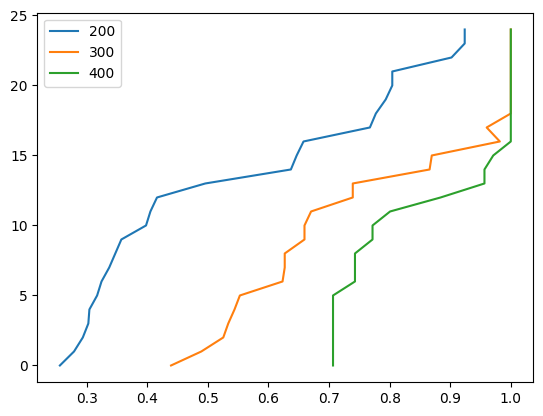

In [27]:
plt.plot(graph_200.values(), graph_200.keys(), label = '200')
plt.plot(graph_300.values(), graph_300.keys(), label = '300')
plt.plot(graph_400.values(), graph_400.keys(), label = '400')
plt.legend()
plt.show

# Generator

In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import random
def generate_points(N):
    # Generate N points for x and y separately
    x = np.random.randn(N)*15_000
    y = np.random.randn(N)*15_000
    min_x = min(x)
    min_y = min(y)
    x = x - min_x - min_y
    y = y - min_x - min_y
    x = np.rint(x)
    y = np.rint(y)
    # Create a DataFrame from the points
    df = pd.DataFrame({'X': x, 'Y': y})
    # Rename the index to "Node"
    df.index.rename('Node', inplace=True)
    df.index += 1
    return df

In [2]:
Node_df = generate_points(100)
x = Node_df['X']
y = Node_df['Y']
Node_df['X'] = Node_df['X'].astype(int)
Node_df['Y'] = Node_df['Y'].astype(int)

In [3]:
import pandas as pd
import numpy as np
from scipy.spatial import distance

def create_connections(df):
    nodes = df.index.values
    coords = df.values
    dist_matrix = distance.cdist(coords, coords, 'cityblock')
    df_dist = pd.DataFrame(dist_matrix, index=nodes, columns=nodes)
    connections = []

    for node in nodes:
        # get 4 closest nodes because the closest one will be the node itself with a distance of 0
        closest_nodes = df_dist[node].nsmallest(4).index.values
        for close_node in closest_nodes:
            # prevent connection with itself
            if node != close_node:
                connections.append([node, close_node])
    
    df_connections = pd.DataFrame(connections, columns=['A', 'B'])
    return df_connections



In [4]:
Connection_df = create_connections(Node_df)

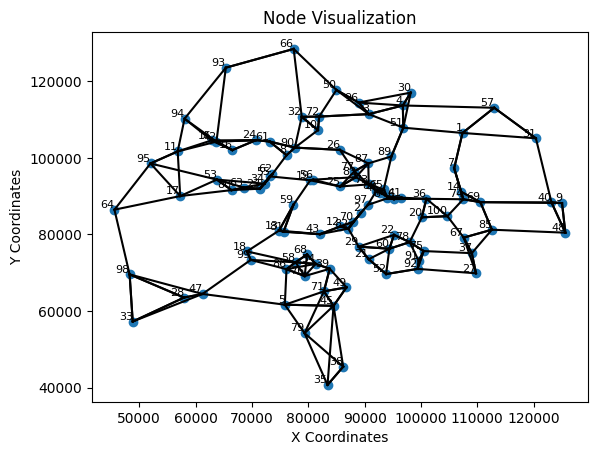

In [5]:
plt.scatter(x, y)
plt.xlabel('X Coordinates')
plt.ylabel('Y Coordinates')
plt.title('Node Visualization')
for i, (x_coord, y_coord) in enumerate(zip(x, y)):
    plt.text(x_coord, y_coord, str(i+1), fontsize=8, verticalalignment='bottom', horizontalalignment='right')
for _, row in Connection_df.iterrows():
    start_node = row['A']
    end_node = row['B']
    plt.plot([x[start_node], x[end_node]], [y[start_node], y[end_node]], 'k-')
plt.show()

In [6]:
import numpy as np
import pandas as pd

def calculate_capacity(node_df, connection_df, min_population=5000, max_population=15000):
    # Assign population to each node using normal distribution
    np.random.seed(42)  # Set a seed for reproducibility
    node_df['Population'] = np.random.randint(min_population, max_population, size=len(node_df))

    # Calculate capacity of each connection by summing node populations
    connection_df['capacity'] = node_df.loc[connection_df['A'], 'Population'].values + \
                                node_df.loc[connection_df['B'], 'Population'].values

    # Create a DataFrame with 'init_node', 'term_node', and 'capacity' columns
    connection_df['capacity'] = connection_df['capacity'].astype(float)  # Convert capacity to float

    output_df = connection_df[['A', 'B', 'capacity']].rename(columns={'A': 'init_node', 'B': 'term_node'})

    return output_df

In [7]:
Data = calculate_capacity(Node_df, Connection_df)

In [8]:
import pandas as pd
import networkx as nx
import concurrent.futures

# Read the DataFrame with connections and capacities
df = Data

# Create a directed graph
G = nx.DiGraph()

# Convert capacity to integers
df['capacity'] = df['capacity'].astype(float)

# Add nodes to the graph
G.add_nodes_from(df['init_node'])
G.add_nodes_from(df['term_node'])

# Add edges to the graph with capacities as edge attributes
for _, row in df.iterrows():
    init_node = row['init_node']
    term_node = row['term_node']
    capacity = row['capacity']
    G.add_edge(init_node, term_node, capacity=capacity)

# Function to find all shortest paths for a pair of nodes
def find_shortest_paths(start_node, end_node):
    return list(nx.all_shortest_paths(G, start_node, end_node, weight='capacity'))

# Find all possible routes and select all shortest paths for each pair of nodes
routes = []
with concurrent.futures.ThreadPoolExecutor() as executor:
    future_to_pair = {executor.submit(find_shortest_paths, start_node, end_node): (start_node, end_node) for start_node in G.nodes for end_node in G.nodes}
    for future in concurrent.futures.as_completed(future_to_pair):
        pair = future_to_pair[future]
        try:
            shortest_paths = future.result()
            for path in shortest_paths:
                route_capacity = min(G[u][v]['capacity'] for u, v in zip(path, path[1:]))
                routes.append({'start_node': pair[0], 'end_node': pair[1], 'route': path, 'capacity': route_capacity})
        except Exception as e:
            print(f"An error occurred for pair {pair}: {e}")

# Convert routes to a DataFrame
Routes_df = pd.DataFrame(routes)
Routes_df['route'] = Routes_df['route'].apply(lambda route: [int(node) for node in route])

# Print the routes DataFrame
Routes_df['route_pairs'] = Routes_df['route'].apply(lambda route: [f"{node}-{next_node}" for node, next_node in zip(route, route[1:])])

An error occurred for pair (65, 22): Target 22 cannot be reached from given sources
An error occurred for pair (86, 56): Target 56 cannot be reached from given sources
An error occurred for pair (65, 21): Target 21 cannot be reached from given sources
An error occurred for pair (86, 55): Target 55 cannot be reached from given sources
An error occurred for pair (65, 20): Target 20 cannot be reached from given sources
An error occurred for pair (65, 19): Target 19 cannot be reached from given sources
An error occurred for pair (65, 18): Target 18 cannot be reached from given sources
An error occurred for pair (86, 53): Target 53 cannot be reached from given sources
An error occurred for pair (65, 17): Target 17 cannot be reached from given sources
An error occurred for pair (86, 52): Target 52 cannot be reached from given sources
An error occurred for pair (65, 16): Target 16 cannot be reached from given sources
An error occurred for pair (65, 15): Target 15 cannot be reached from given 

In [9]:
def find_distance(pair):
    node1, node2 = pair.split('-')
    x1 = Node_df.iloc[int(node1) - 1]['X']
    x2 = Node_df.iloc[int(node2) - 1]['X']
    y1 = Node_df.iloc[int(node1) - 1]['Y']
    y2 = Node_df.iloc[int(node2) - 1]['Y']
    return ((x1-x2)**2 + (y1-y2)**2)**0.5

distances = dict()
for i in range(len(Data)):
    distance = f"{int(Data.iloc[i]['init_node'])}-{int(Data.iloc[i]['term_node'])}"
    distances[distance] = find_distance(distance)

    
# Function to calculate the summary distance for a route pair
def calculate_summary_distance(route_pairs):
    return sum(distances.get(pair, 0) for pair in route_pairs)

# Calculate the summary distances for each route_pairs entity
Routes_df['summary_distance'] = Routes_df['route_pairs'].apply(calculate_summary_distance)

# Print the updated routes DataFrame with summary distances
# print(routes_df)


In [10]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

# Set the max_distance a car can drive without charging
max_distance = 75000 # for example
n_clusters = 20

# Filter routes that a car can drive without charging
viable_routes_df = Routes_df[Routes_df['summary_distance'] <= max_distance]

if viable_routes_df.empty:
    raise ValueError("No viable routes! Increase max_distance.")

# Now, we'll perform clustering on the 'capacity' of the routes
# Convert 'capacity' into a 2D numpy array
X = np.array(viable_routes_df['capacity']).reshape(-1, 1)

# Number of clusters corresponds to the number of desired charging stations

kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)

# Assign each route to a cluster
viable_routes_df['cluster'] = kmeans.labels_

charging_stations = []

# For each cluster, find the route with the maximum capacity
for i in range(n_clusters):
    cluster_routes = viable_routes_df[viable_routes_df['cluster'] == i]
    
    if cluster_routes.empty:
        continue  # Skip to the next iteration if there are no routes in this cluster
    
    # Choose the first route with the maximum capacity
    best_route = cluster_routes[cluster_routes['capacity'] == cluster_routes['capacity'].max()].iloc[0]
    
    # Choose the node with the highest capacity within this route
    nodes_in_route = best_route['route']
    node_capacities = [(node, Routes_df[Routes_df['start_node'] == node]['capacity'].max()) for node in nodes_in_route]
    best_node, _ = max(node_capacities, key=lambda x: x[1])
    
    # Add the best_node's coordinates to the list of charging stations
    charging_stations.append(Node_df.loc[int(best_node)])

# Now charging_stations contains the coordinates of the charging stations.
#print(charging_stations)

C:\Users\PC-1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\PC-1\AppData\Local\Temp\ipykernel_15304\2210207157.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  viable_routes_df['cluster'] = kmeans.labels_


In [11]:
capacities = dict()
for i in range(len(Data)):
    if Data['term_node'][i] not in capacities.keys():
        capacities[Data['term_node'][i]] = Data['capacity'][i]
    else:
        capacities[Data['term_node'][i]] += Data['capacity'][i]    

In [12]:
# Convert charging_stations to a dictionary for uniqueness
charging_stations_dict = {station.name: station for station in charging_stations}

# Store the original number of charging stations
original_num_stations = len(charging_stations_dict)

# Sort the capacities dict based on values (in descending order)
sorted_capacities = dict(sorted(capacities.items(), key=lambda item: item[1], reverse=True))

# Iterate over the sorted capacities dict
for node, capacity in sorted_capacities.items():
    # If the node is not already in the charging_stations dictionary
    if int(node) not in charging_stations_dict:
        # Get the node from node_df and add it to the charging_stations dictionary
        charging_stations_dict[int(node)] = Node_df.loc[int(node)]

    # Check if the number of charging stations is equal to n_clusters
    if len(charging_stations_dict) == n_clusters:
        break

# Convert the dictionary back to a list
charging_stations = list(charging_stations_dict.values())

# Calculate the number of new stations added
num_new_stations = len(charging_stations) - original_num_stations

if num_new_stations == 0 and len(charging_stations) < n_clusters:
    print("Not enough different stations to reach the desired number of clusters.")
else:
    print(f"Added {num_new_stations} new station(s) to charging_stations list.")


Added 7 new station(s) to charging_stations list.


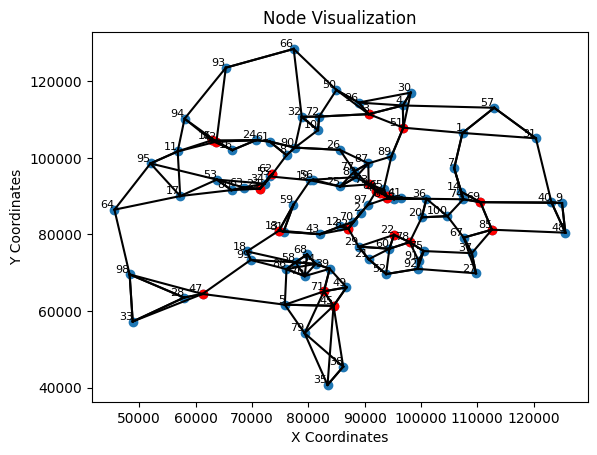

In [13]:
import matplotlib.pyplot as plt

plt.scatter(x, y)
plt.xlabel('X Coordinates')
plt.ylabel('Y Coordinates')
plt.title('Node Visualization')
for i, (x_coord, y_coord) in enumerate(zip(x, y)):
    plt.text(x_coord, y_coord, str(i+1), fontsize=8, verticalalignment='bottom', horizontalalignment='right')

# Extracting X and Y coordinates of charging stations
x_charging = [station['X'] for station in charging_stations]
y_charging = [station['Y'] for station in charging_stations]

# Plotting charging stations
plt.scatter(x_charging, y_charging, color='red')

for _, row in Connection_df.iterrows():
    start_node = row['A']
    end_node = row['B']
    plt.plot([x[start_node], x[end_node]], [y[start_node], y[end_node]], 'k-')

plt.show()

In [14]:
def get_node_numbers(charging_stations, Node_df):
    node_numbers = []
    for station in charging_stations:
        match = Node_df[(Node_df['X'] == station['X']) & (Node_df['Y'] == station['Y'])]
        node_numbers.append(match.index[0])
    return node_numbers

# Call the function with your data
node_numbers = get_node_numbers(charging_stations, Node_df)

# Print the node numbers of the charging stations
print(set(node_numbers))


{3, 13, 15, 22, 23, 42, 44, 45, 46, 47, 51, 62, 69, 71, 73, 78, 82, 84, 85, 88}


In [15]:
def find_distances(route_pairs, node_numbers, distances_dict, max_distance):
    route_nodes = []
    charging_stations = []
    distances = []

    # Extract nodes from route pairs and add to route_nodes
    for route_pair in route_pairs:
        node_a, node_b = map(int, route_pair.split('-'))
        if node_a not in route_nodes:
            route_nodes.append(node_a)
        if node_b not in route_nodes:
            route_nodes.append(node_b)

    # Determine which nodes are charging stations
    for node in route_nodes:
        if node in node_numbers:
            charging_stations.append(node)

    # Special case when starting point is a charging station
    if route_nodes[0] in charging_stations:
        charging_stations.remove(route_nodes[0])

    if len(charging_stations) == 0:
        # No charging station, return the total route distance
        total_distance = 0
        for i in range(len(route_nodes)-1):
            total_distance += distances_dict[f'{route_nodes[i]}-{route_nodes[i+1]}']
        distances.append(total_distance)
    else:
        # There are charging stations, calculate distances between them
        prev_station = route_nodes[0]
        for station in charging_stations:
            distance = 0
            i = route_nodes.index(prev_station)
            while i < len(route_nodes) and route_nodes[i] != station:
                distance += distances_dict[f'{route_nodes[i]}-{route_nodes[i+1]}']
                i += 1
            distances.append(distance)
            prev_station = station

        # Distance from last charging station to end of route
        distance = 0
        i = route_nodes.index(prev_station)
        while i < len(route_nodes) - 1:
            distance += distances_dict[f'{route_nodes[i]}-{route_nodes[i+1]}']
            i += 1
        distances.append(distance)

    return distances
# Apply the function to the 'route_pairs' column
Routes_df['distances_between_stations'] = Routes_df['route_pairs'].apply(
    lambda route_pairs: find_distances(
        route_pairs, 
        node_numbers, 
        distances, 
        max_distance
    )
)
def count_charging_stations(route_pairs, node_numbers):
    route_nodes = []
    charging_stations = []

    # Extract nodes from route pairs and add to route_nodes
    for route_pair in route_pairs:
        node_a, node_b = map(int, route_pair.split('-'))
        if node_a not in route_nodes:
            route_nodes.append(node_a)
        if node_b not in route_nodes:
            route_nodes.append(node_b)

    # Determine which nodes are charging stations
    for node in route_nodes:
        if node in node_numbers:
            charging_stations.append(node)

    # Special case when starting point is a charging station
    if route_nodes[0] in charging_stations:
        charging_stations.remove(route_nodes[0])

    return len(charging_stations)


# Apply the function to the 'route_pairs' column
Routes_df['station_count'] = Routes_df['route_pairs'].apply(
    lambda route_pairs: count_charging_stations(
        route_pairs, 
        node_numbers
    )
)
def check_max_distance(distances, max_distance):
    # Check if any distance in distances is greater than max_distance
    for distance in distances:
        if distance > max_distance:
            return False

    # If none of the distances are greater than max_distance
    return True


# Apply the function to the 'distances_between_stations' column
Routes_df['within_max_distance'] = Routes_df['distances_between_stations'].apply(
    lambda distances: check_max_distance(distances, max_distance)
)


In [16]:
sum(Routes_df['within_max_distance'])/len(Routes_df)

0.9984558369363805